In [1]:
import os
import numpy as np
import pandas as pd
import shutil
from read_roi import read_roi_file
import tifffile
import matplotlib.pyplot as plt
import create_mask_for_region
from datetime import datetime
from contour_visualization import *

#import shap
# read heatmap plots
#import Heatmap_plots as hmp
import seaborn as sns
import pickle
import tifffile as tiff

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list

In [2]:
# set figure key
figure_key = 'Figure1'

In [3]:
# set paths
result_paths = r"\\10.159.50.7\analysis2\Ken\LSMS\Opioid"
rootpath = r"G:\My Drive\Opioid_whole_brain_manuscript"
metapath = os.path.join(rootpath,"meta")
analysis_resultpath = os.path.join(rootpath,"result")
analysis_root_figurepath = os.path.join(rootpath,"figure")
analysis_figurepath = os.path.join(analysis_root_figurepath,figure_key)
for path in [analysis_resultpath,analysis_root_figurepath,analysis_figurepath]:
    if not os.path.exists(path):
        os.mkdir(path)

# load meta info of the files
metadf = pd.read_csv(os.path.join(metapath,"OP_meta.csv"),index_col= False)
# temporary drop of A7 due to missing data
metadf = metadf[metadf.ID != 'A7'].reset_index(drop = True)
# load brain atlas to register
atlas_df = pd.read_csv(r"\\10.159.50.7\Analysis2\Ken\ClearMap\clearmap_ressources_mouse_brain\ClearMap_ressources\Regions_annotations\atlas_info_KimRef_FPbasedLabel_v4.0_brain_with_size_with_curated_with_cleaned_acronyms.csv",index_col = False)
metacolumns = ['id','acronym','parent_acronym','parent_id','structure_order']
contour_img = tifffile.imread(r"\\10.159.50.7\Analysis2\Ken\ClearMap\clearmap_ressources_mouse_brain\ClearMap_ressources\Regions_annotations\Kim_ref_adult_FP-label_v2.9_contour_map.tif")
# retrieve list of files
fnames =  [f for f in metadf.fname.values if 'DONE' in f]

In [4]:
#Conditions = metadf.Condition.unique()
# Use only morphine related groups
Conditions = ['Saline','Acute_Morphine','Chronic_Morphine','Withdrawal_Morphine','Chronic_Morphine_21','Withdrawal_Morphine_21',]
print(Conditions)

# subset the meta dataframe
metadf = metadf[metadf.Condition.isin(Conditions)]

['Saline', 'Acute_Morphine', 'Chronic_Morphine', 'Withdrawal_Morphine', 'Chronic_Morphine_21', 'Withdrawal_Morphine_21']


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from adjustText import adjust_text

# Set matplotlib parameters for white text on transparent background
plt.rcParams.update({
    'figure.facecolor': 'none',  # Transparent figure background
    'axes.facecolor': 'none',    # Transparent axes background
    'axes.edgecolor': 'black',   # White axes edge color
    'axes.labelcolor': 'black',  # White axis labels
    'xtick.color': 'black',      # White tick labels
    'ytick.color': 'black',      # White tick labels
    'legend.facecolor': 'none',  # Transparent legend background
    'legend.edgecolor': 'none',  # Transparent legend edgecolor
    'text.color': 'black',       # White text color
    'font.family':'Arial',
    'pdf.fonttype':42,
    'ps.fonttype':42,
   
})
#important for text to be detected when importing saved figures into illustrator


In [6]:
with open(os.path.join(analysis_resultpath,f'curated_acronym.pickle'), 'rb') as handle:
    curated_acronyms = pickle.load(handle)

with open(os.path.join(analysis_resultpath,f'ancestor_curated_acronym.pickle'), 'rb') as handle:
    ancestor_curated_acronyms = pickle.load(handle,)

In [7]:
default_depth = 4
# set heatmap variables
vmin= -5
vmax = 10

#Conditions = metadf.Condition.unique()
# Use only morphine related groups
Conditions = ['Saline','Acute_Morphine','Chronic_Morphine','Withdrawal_Morphine','Chronic_Morphine_21','Withdrawal_Morphine_21',]
print(Conditions)
#Condition_figure_name = ['Saline','Acute','Chronic 1 day','W.D. 1 day','Chronic 21 days','W.D. 21 days'] # changed this to betterones
Condition_figure_name = ['Saline','Acute','Chronic','Early WD','Re-exposure','Late WD'] 
Condition_color = ['gray','lime','orange','cyan','blue','purple']
# subset the meta dataframe
metadf = metadf[metadf.Condition.isin(Conditions)]

# load and subset dataframes
pivot_heatmap_df = pd.read_csv(os.path.join(analysis_resultpath,'long_pivoted_heatmap_df_with_normalized_density.csv'),index_col = 0)
pivot_heatmap_df = pivot_heatmap_df[metadf[metadf.Condition.isin(Conditions)]['ID'].values]
merge_df  = pd.read_csv(os.path.join(analysis_resultpath,'Ex_639_Ch2_stitched_long_merge_Annotated_counts_with_leaf_with_density_with_normalized_density.csv'),index_col = 0)
merge_df = merge_df[merge_df.Condition.isin(Conditions)]
# Load the acronyms for plotting
with open(os.path.join(analysis_resultpath,f'curated_acronym.pickle'), 'rb') as handle:
    curated_acronyms = pickle.load(handle)

with open(os.path.join(analysis_resultpath,f'ancestor_curated_acronym.pickle'), 'rb') as handle:
    ancestor_curated_acronyms = pickle.load(handle,)


['Saline', 'Acute_Morphine', 'Chronic_Morphine', 'Withdrawal_Morphine', 'Chronic_Morphine_21', 'Withdrawal_Morphine_21']


remove HB and CBL from the list of ancestores

In [8]:
# Update the ancestor curated acronyms so it matches the tree devisions
unique_ancestor_curated_acronyms = ['Isocortex','OLF','HPF','CTXsp','STR','PAL','TH','HY','MB',]
#unique_ancestor_curated_acronyms = ['Isocortex','OLF','HPF','CTXsp','STR','PAL','TH','HY','MB','HB','CBL']

# get a list of idx for the ancestors
ancestor_names = [atlas_df.loc[atlas_df.acronym == f,'name'].values[0] for f in unique_ancestor_curated_acronyms]
ancestor_idxs = [atlas_df.loc[atlas_df.acronym == f,'id'].values[0] for f in unique_ancestor_curated_acronyms]
'''
curated_acronyms = []
ancestor_curated_acronyms = []
for idx,i in enumerate(ancestor_idxs):
    create_mask_for_region.get_subregions(atlas_df,i,return_original = True)
    tdf = create_mask_for_region.get_subregions(atlas_df,i,return_original = True)
    curated_acronyms += list(tdf[tdf.Curated_list].acronym)
    ancestor_curated_acronyms += [unique_ancestor_curated_acronyms[idx]]*tdf[tdf.Curated_list].shape[0]

# save the new list of acronyms
with open(os.path.join(analysis_resultpath,f'curated_acronym.pickle'), 'wb') as handle:
    pickle.dump(curated_acronyms,handle,)

with open(os.path.join(analysis_resultpath,f'ancestor_curated_acronym.pickle'), 'wb') as handle:
    pickle.dump(ancestor_curated_acronyms,handle,)'''

"\ncurated_acronyms = []\nancestor_curated_acronyms = []\nfor idx,i in enumerate(ancestor_idxs):\n    create_mask_for_region.get_subregions(atlas_df,i,return_original = True)\n    tdf = create_mask_for_region.get_subregions(atlas_df,i,return_original = True)\n    curated_acronyms += list(tdf[tdf.Curated_list].acronym)\n    ancestor_curated_acronyms += [unique_ancestor_curated_acronyms[idx]]*tdf[tdf.Curated_list].shape[0]\n\n# save the new list of acronyms\nwith open(os.path.join(analysis_resultpath,f'curated_acronym.pickle'), 'wb') as handle:\n    pickle.dump(curated_acronyms,handle,)\n\nwith open(os.path.join(analysis_resultpath,f'ancestor_curated_acronym.pickle'), 'wb') as handle:\n    pickle.dump(ancestor_curated_acronyms,handle,)"

remove CBL and MB subtree from the atlas file and the merge_df

In [9]:
# remove CBL and MB subtree from the data. These regions had bad registration quality and low interest
remove_ancestor_ids = atlas_df[(atlas_df.acronym == 'HB') | (atlas_df.acronym == 'CBL')]['id'].values
remove_df = pd.concat([create_mask_for_region.get_subregions(atlas_df,idx,return_original = True) for idx in remove_ancestor_ids],axis = 0)
sub_atlas_df = atlas_df.set_index(['id']).drop(remove_df['id'].values)
merge_df = merge_df[merge_df.acronym.isin(sub_atlas_df.acronym.unique())]

set up the metacolumns to be compatible for GLM

In [10]:
# load meta info of the files
metadf['age'] = [(datetime.strptime( pday, '%m/%d/%Y') - datetime.strptime( dob, '%m/%d/%Y')).days for pday,dob in metadf.loc[:,['Date_Perfusion','DOB']].values]
atlasmeta = merge_df.reset_index().loc[merge_df.reset_index().ID =='A1',['id','parent_id','acronym','name','parent_acronym']]

#metaexog = metadf[['Condition','Sex','BW','age','Staining_Batch']]
#metacolumns = ['Saline','Acute_Morphine','Chronic_Morphine','Sex_d','Batch_d']


In [11]:
# change categorical values to dummy chategories dtypes
sex_category = pd.CategoricalDtype(categories=['F', 'M'], ordered=False)
condition_category = pd.CategoricalDtype(categories=Conditions, ordered=True)
batch_category = pd.CategoricalDtype(categories=[1,2,3,4], ordered=False)

merge_df['Sex']             = merge_df['Sex'].astype(sex_category)
merge_df['Condition']       = merge_df['Condition'].astype(condition_category)

merge_df['Staining_Batch']  = merge_df['Staining_Batch'].astype(batch_category)

# create dummy cats
condition_dummies           = pd.get_dummies(merge_df['Condition'])
sex_dummies                 = pd.get_dummies(merge_df['Sex']).loc[:,['F']].rename(columns = {'F':'Sex_d'}) # female 1
batch_dummies = pd.get_dummies(merge_df['Staining_Batch'])
batch_dummies.columns = [f'Batch_{c}_d' for c in range(4)]

merge_df                    = pd.concat([merge_df,condition_dummies,sex_dummies,batch_dummies],axis =1)

In [12]:
# add flags for conditions
#merge_df = pd.merge(merge_df,metadf[['ID','Acute_flag','Chronic_flag','Spontaneous_flag']],left_on = 'ID',right_on = 'ID')

In [13]:
# calculate effect size raw
raw_effect_size_df = merge_df[['acronym','Condition','density']].groupby(['acronym','Condition',]).mean().reset_index()\
.pivot(columns = 'Condition',index = 'acronym',values = 'density')

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_209520\3994839575.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  raw_effect_size_df = merge_df[['acronym','Condition','density']].groupby(['acronym','Condition',]).mean().reset_index()\


In [14]:
atlas_df.loc[atlas_df.acronym.isin(curated_acronyms),['acronym','name']].to_csv(os.path.join(metapath,'clean_curated_acronyms.csv'),index = False)

Prepare heatmaps into a dictionary format

In [15]:
# read an annotated atlas file
atlas_img = tifffile.imread(r"\\10.159.50.7\Analysis2\Ken\LSMS\ClearMap\clearmap_ressources_mouse_brain\ClearMap_ressources\Regions_annotations\Kim_ref_adult_FP-label_v4.0.tif")

# Figure 1

## Figure 1B

In [16]:
# pannel
pannel_key = 'B'

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_58588\295315879.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data = tdata,y = 'Condition',x = 'newcounts',\
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_58588\295315879.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data = tdata,y = 'Condition',x = 'newcounts',\
C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_58588\295315879.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_yticklabels(Condition_figure_name,rotation= -0)


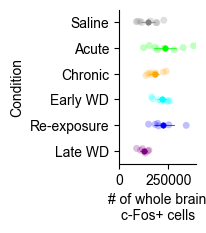

In [79]:
from statannotations.Annotator import Annotator

pairs = [("Saline",c) for c in Conditions[1:]]

fig,axs = plt.subplots(1,1,figsize = (1,2))
merge_df.Condition = merge_df.Condition.astype('str')
tdata = merge_df.loc[merge_df.parent_acronym == 'grey',
             ['ID','Condition','newcounts']].groupby(['ID','Condition']).sum().reset_index().dropna()

sns.stripplot(data = tdata,y = 'Condition',x = 'newcounts',\
        order = Conditions,ax = axs,palette = Condition_color,alpha = 0.25)
sns.pointplot(data = tdata,y = 'Condition',x = 'newcounts',\
        order = Conditions,ax = axs,palette = Condition_color,
markers="o", markersize=4, linestyle="none",linewidth = 0.5)        
sns.despine()
axs.set_xlabel('# of whole brain\nc-Fos+ cells')
axs.set_yticklabels(Condition_figure_name,rotation= -0)
axs.set_xlim(0,)


fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches = 'tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches = 'tight',dpi = 216)

## Linear regression

### Data preparation

The linear regression of the spatial data was conducted by using sm.OLS with a constant added.
The variables used ,were bw, sex, age. The batch was not able to be added to the regression since some conditions coinsided with the batch.

In [26]:
# collect the variables
variable_df = merge_df.loc[merge_df.acronym == 'CH',['fname','Condition','BW','Age','Sex_d',]+Conditions]
variable_df = variable_df.set_index('fname')

The cell heatmap data was stored in a zarr format, the order of the files are stored in a npy file.

In [27]:
# read the file names
fnamelist = np.load(os.path.join(analysis_resultpath,'fnamelist.npy'),)

# sort the fnames according to the order in the meta dataframe
variable_df = variable_df.loc[fnamelist,:]

In [28]:
# sort the data frame
metadf = metadf.set_index('fname').loc[fnamelist,:]

In [29]:
# remove the non brain regions that have 0 values in the atlas_img
# remove the non brain regions that are not included in the analysis
# get the index of atlas_img values that are in atlas_df['id'].values
brain_voxels = np.where(np.isin(atlas_img.flatten(),atlas_df['id'].values))[0]

In [30]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler 

# Select only continuous variables for scaling
continuous_vars = ['BW', 'Age']  # Modify as needed
scaler = StandardScaler(with_mean = True)
variable_df[continuous_vars] = scaler.fit_transform(variable_df[continuous_vars])


In [31]:
# treat the saline as baseline. Remove from the variable dataframe
variable_df = variable_df.drop(columns = 'Saline')

In [32]:
# add a constant
variable_df['constant'] = 1


# sort the variable data frame
variable_df = variable_df.loc[metadf.index]
variable_df = variable_df.drop(columns = 'Condition')
variables = np.array(variable_df.astype('float'))


[9.47594802 7.35121597 3.2144049  2.69836832 2.46414477 2.41946804
 1.70054346 1.36208321 0.93781054]


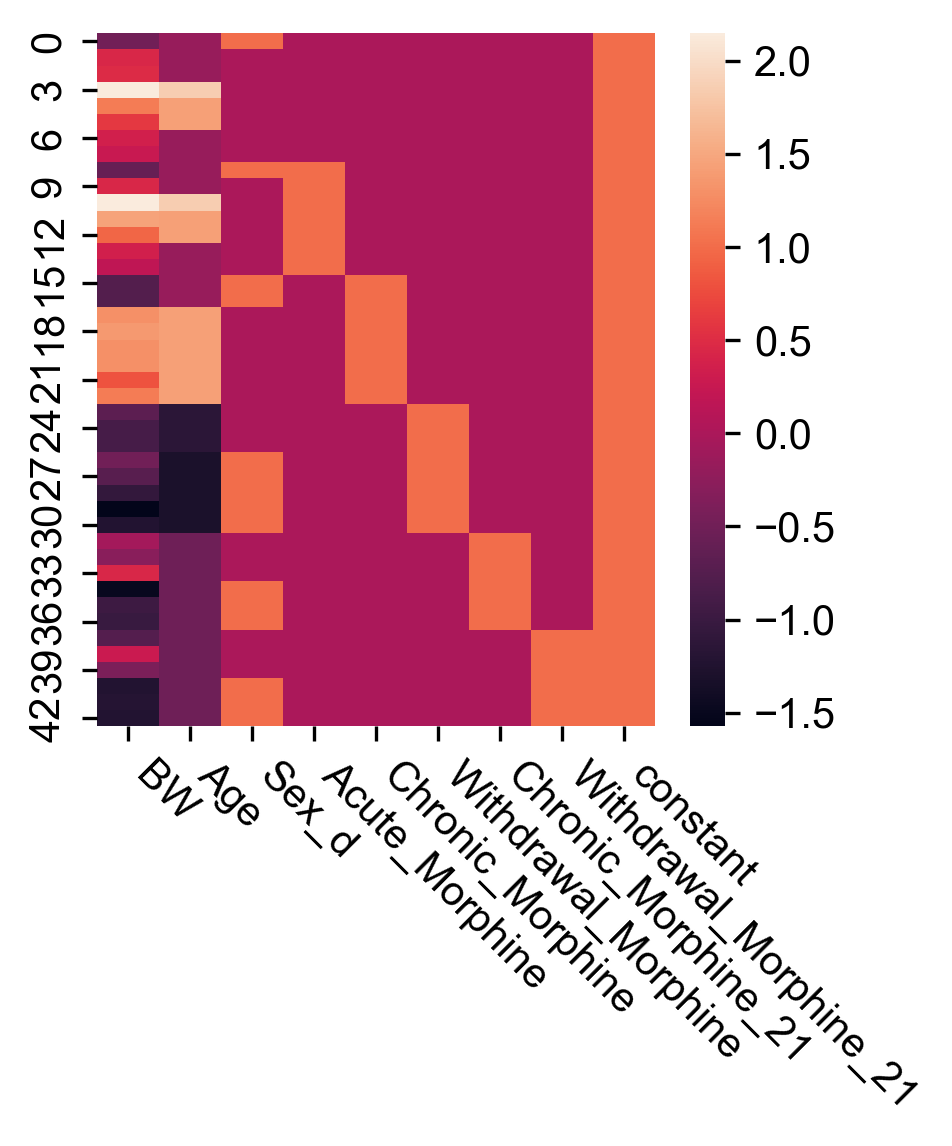

In [33]:
# visualize the variables
fig,axs = plt.subplots(1,1,figsize = (3,3),dpi = 300)
sns.heatmap(variables,ax=  axs)
axs.set_xticklabels(variable_df.columns,rotation = -45,ha = 'left')
print(np.linalg.svdvals(variables))

In [88]:
# read the heatmap array
import dask.array as da

# write as zarr array to os.path.join(analysis_resultpah,'heatmap_array.zarr')
heatmap_da = da.from_zarr(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos",'heatmap_array'), mode="r")

In [89]:
# read the heatmap array and take areas only with brain voxels
brain_heatmap = heatmap_da[:,brain_voxels].compute()

### Regression

In [90]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
models = sm.OLS(brain_heatmap, variables,).fit()

Calculate the non-experiment variables predictions, and use it to calculate the adjusted c-Fos signal for each subject. This will be Experiment vars . Experiment beta + residuals.

In [91]:
# set the non experiment variables
non_exp_vars = variable_df.columns.drop(Conditions[1:])  # adjust to match your column names
non_exp_idx = [f for  f,col in enumerate(variable_df.columns) if col in non_exp_vars]
# get the non experiment variables
non_exp_matrix = variable_df[non_exp_vars].values.astype('float')
# get the non experiment beta
non_exp_beta = models.params[non_exp_idx]

# get the prediction
non_exp_prediction = non_exp_matrix @ non_exp_beta


cFos[subject]=Xexpβexp+Xnon-expβnon-exp+β0+ε


adjustedcFos[subject] = cFos[subject] - Xnon-expβnon-exp -  β0


β0: constant

In [92]:
# subtract the non experiment prediction from the brain heatmap
# this will result in adjusted_cFos[subject] = Xexp.dot(beta_exp) + residuals
adjusted_brain_heatmap = brain_heatmap - non_exp_prediction

In [93]:
# save the adjusted_brain_heatmap as a zarr array after recovering the non brain_voxels
adjusted_brain_heatmap_full = np.zeros(heatmap_da.shape)
adjusted_brain_heatmap_full[:,brain_voxels] = adjusted_brain_heatmap

# save the adjusted brain heatmap as a zarr array
adjusted_brain_heatmap_da = da.from_array(adjusted_brain_heatmap_full, chunks=heatmap_da.chunks)
adjusted_brain_heatmap_da.to_zarr(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",'adjusted_brain_heatmap.zarr'), overwrite=True)

In [18]:
# read adjusted_brain_heatmap from zarr
import dask.array as da
adjusted_brain_heatmap_da = da.from_zarr(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",'adjusted_brain_heatmap.zarr'), mode="r")


In [42]:
np.sum(metadf.Condition == condition)

np.int64(6)

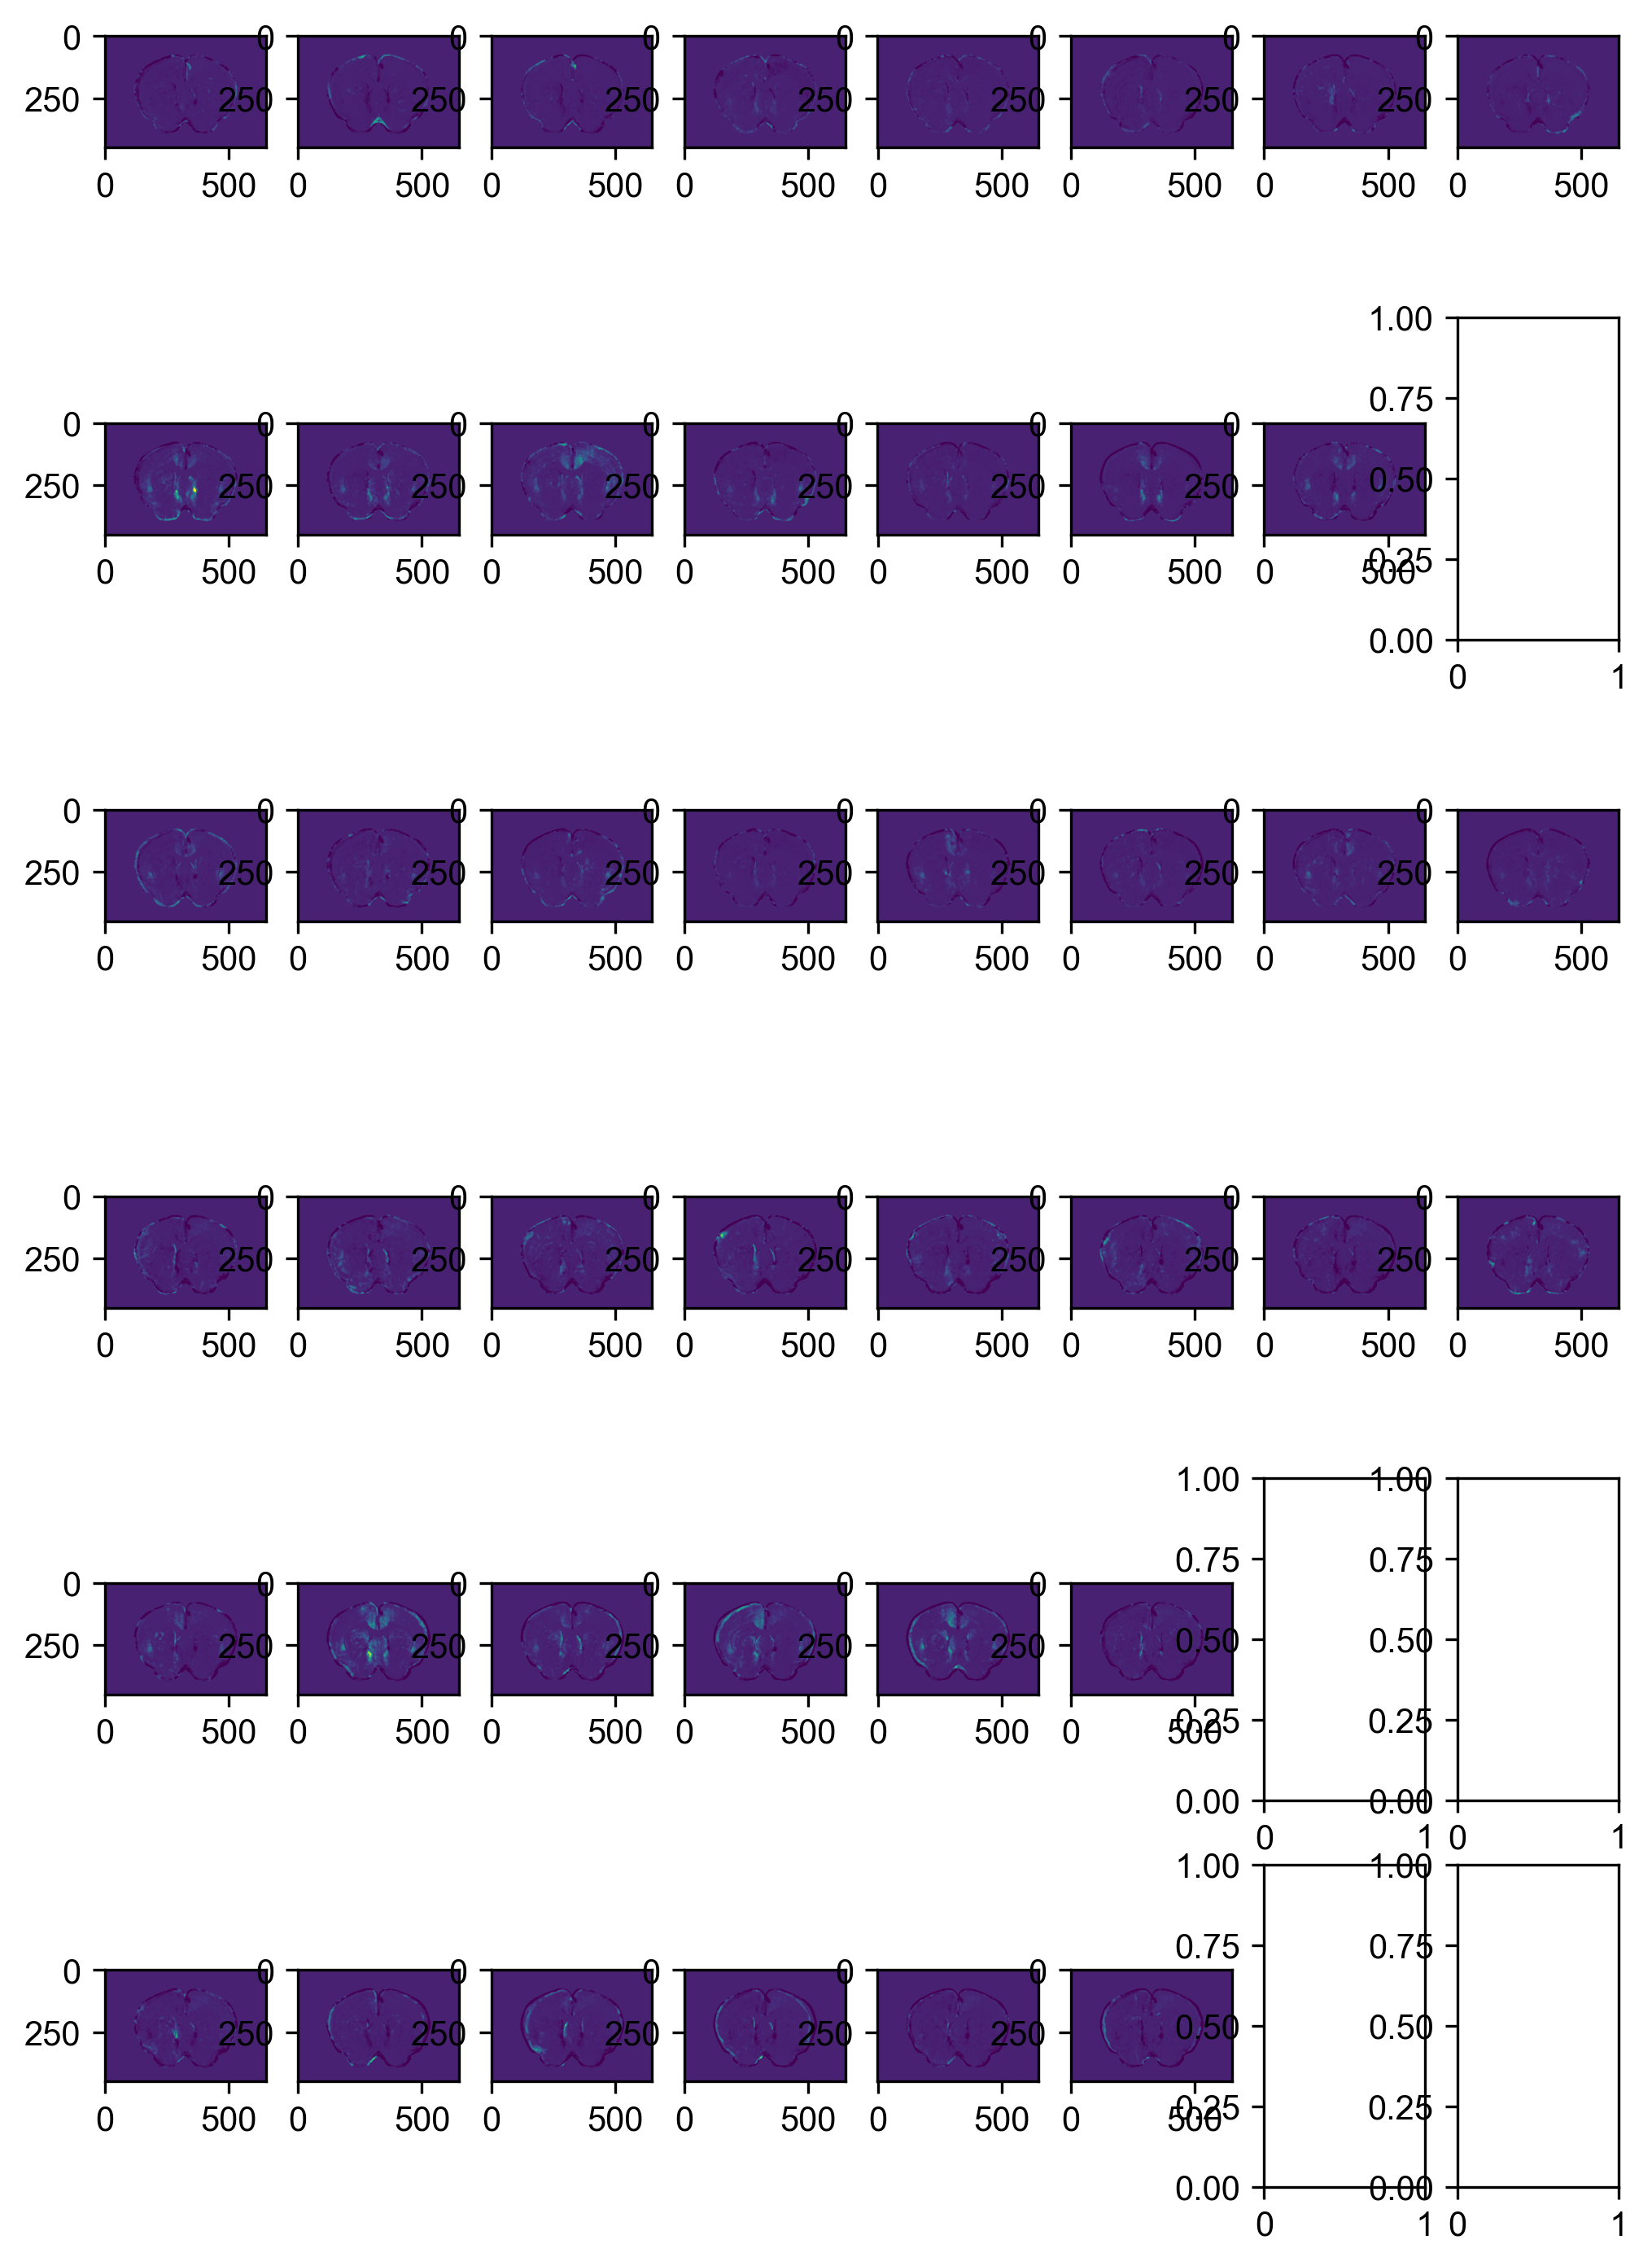

In [ ]:
fig,axs = plt.subplots(len(Conditions),8,figsize = (8,len(Conditions)*1.2),dpi = 300)
for idx,condition in enumerate(Conditions):
    for sidx in range(np.sum(metadf.Condition == condition)):
        axs[idx,sidx].imshow(adjusted_brain_heatmap_da[metadf.Condition == condition,:][sidx,:]\
                             .reshape(atlas_img.shape)[100,:,:],vmin = -10,vmax = 100)

In [94]:
del adjusted_brain_heatmap_full

In [95]:
# write the beta coefs
for variable_idx,variable_name in enumerate(variable_df.columns):
    print("Writing the betas for",variable_name)
    temp_img = np.zeros_like(atlas_img.flatten(),dtype='float64')
    temp_img[brain_voxels] = models.params[variable_idx,:]
    np.save(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'{variable_name}_betas.npy'),np.reshape(temp_img,atlas_img.shape))
    tiff.imwrite(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'{variable_name}_betas.tif'),np.reshape(temp_img,atlas_img.shape).astype('float64'))

Writing the betas for BW
Writing the betas for Age
Writing the betas for Sex_d
Writing the betas for Acute_Morphine
Writing the betas for Chronic_Morphine
Writing the betas for Withdrawal_Morphine
Writing the betas for Chronic_Morphine_21
Writing the betas for Withdrawal_Morphine_21
Writing the betas for constant


## For unbiased preprocessing

In [35]:
# set the non experiment variables
non_exp_vars = variable_df.columns.drop(Conditions[1:])  # adjust to match your column names
non_exp_idx = [f for  f,col in enumerate(variable_df.columns) if col in non_exp_vars]
# get the non experiment variables
non_exp_matrix = variable_df[non_exp_vars].values.astype('float')
print(non_exp_vars)

Index(['BW', 'Age', 'Sex_d', 'constant'], dtype='object')


<Axes: >

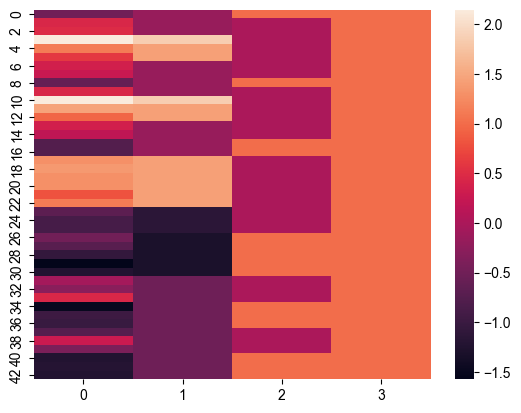

In [36]:
sns.heatmap(non_exp_matrix)

In [37]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
models = sm.OLS(brain_heatmap, non_exp_matrix,).fit()

In [38]:
# store the intercept coefficient
intercept_coef = models.params[3]

In [39]:
# calculate the adjusted brain_heatmap
# non-experiment predictions is subtracted from the raw c-Fos data
adjusted_brain_heatmap = intercept_coef + models.resid
#assert brain_heatmap - non_exp_matrix[:,:3] @ models.params[:3] == adjusted_brain_heatmap

In [40]:
# save the adjusted_brain_heatmap as a zarr array after recovering the non brain_voxels
adjusted_brain_heatmap_full = np.zeros(heatmap_da.shape)
adjusted_brain_heatmap_full[:,brain_voxels] = adjusted_brain_heatmap

# save the adjusted brain heatmap as a zarr array
adjusted_brain_heatmap_da = da.from_array(adjusted_brain_heatmap_full, chunks=heatmap_da.chunks)
adjusted_brain_heatmap_da.to_zarr(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",'unbiased_adjusted_brain_heatmap'), overwrite=True)

In [49]:
adjusted_brain_heatmap_da = da.from_zarr(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",'unbiased_adjusted_brain_heatmap'), mode = 'r')

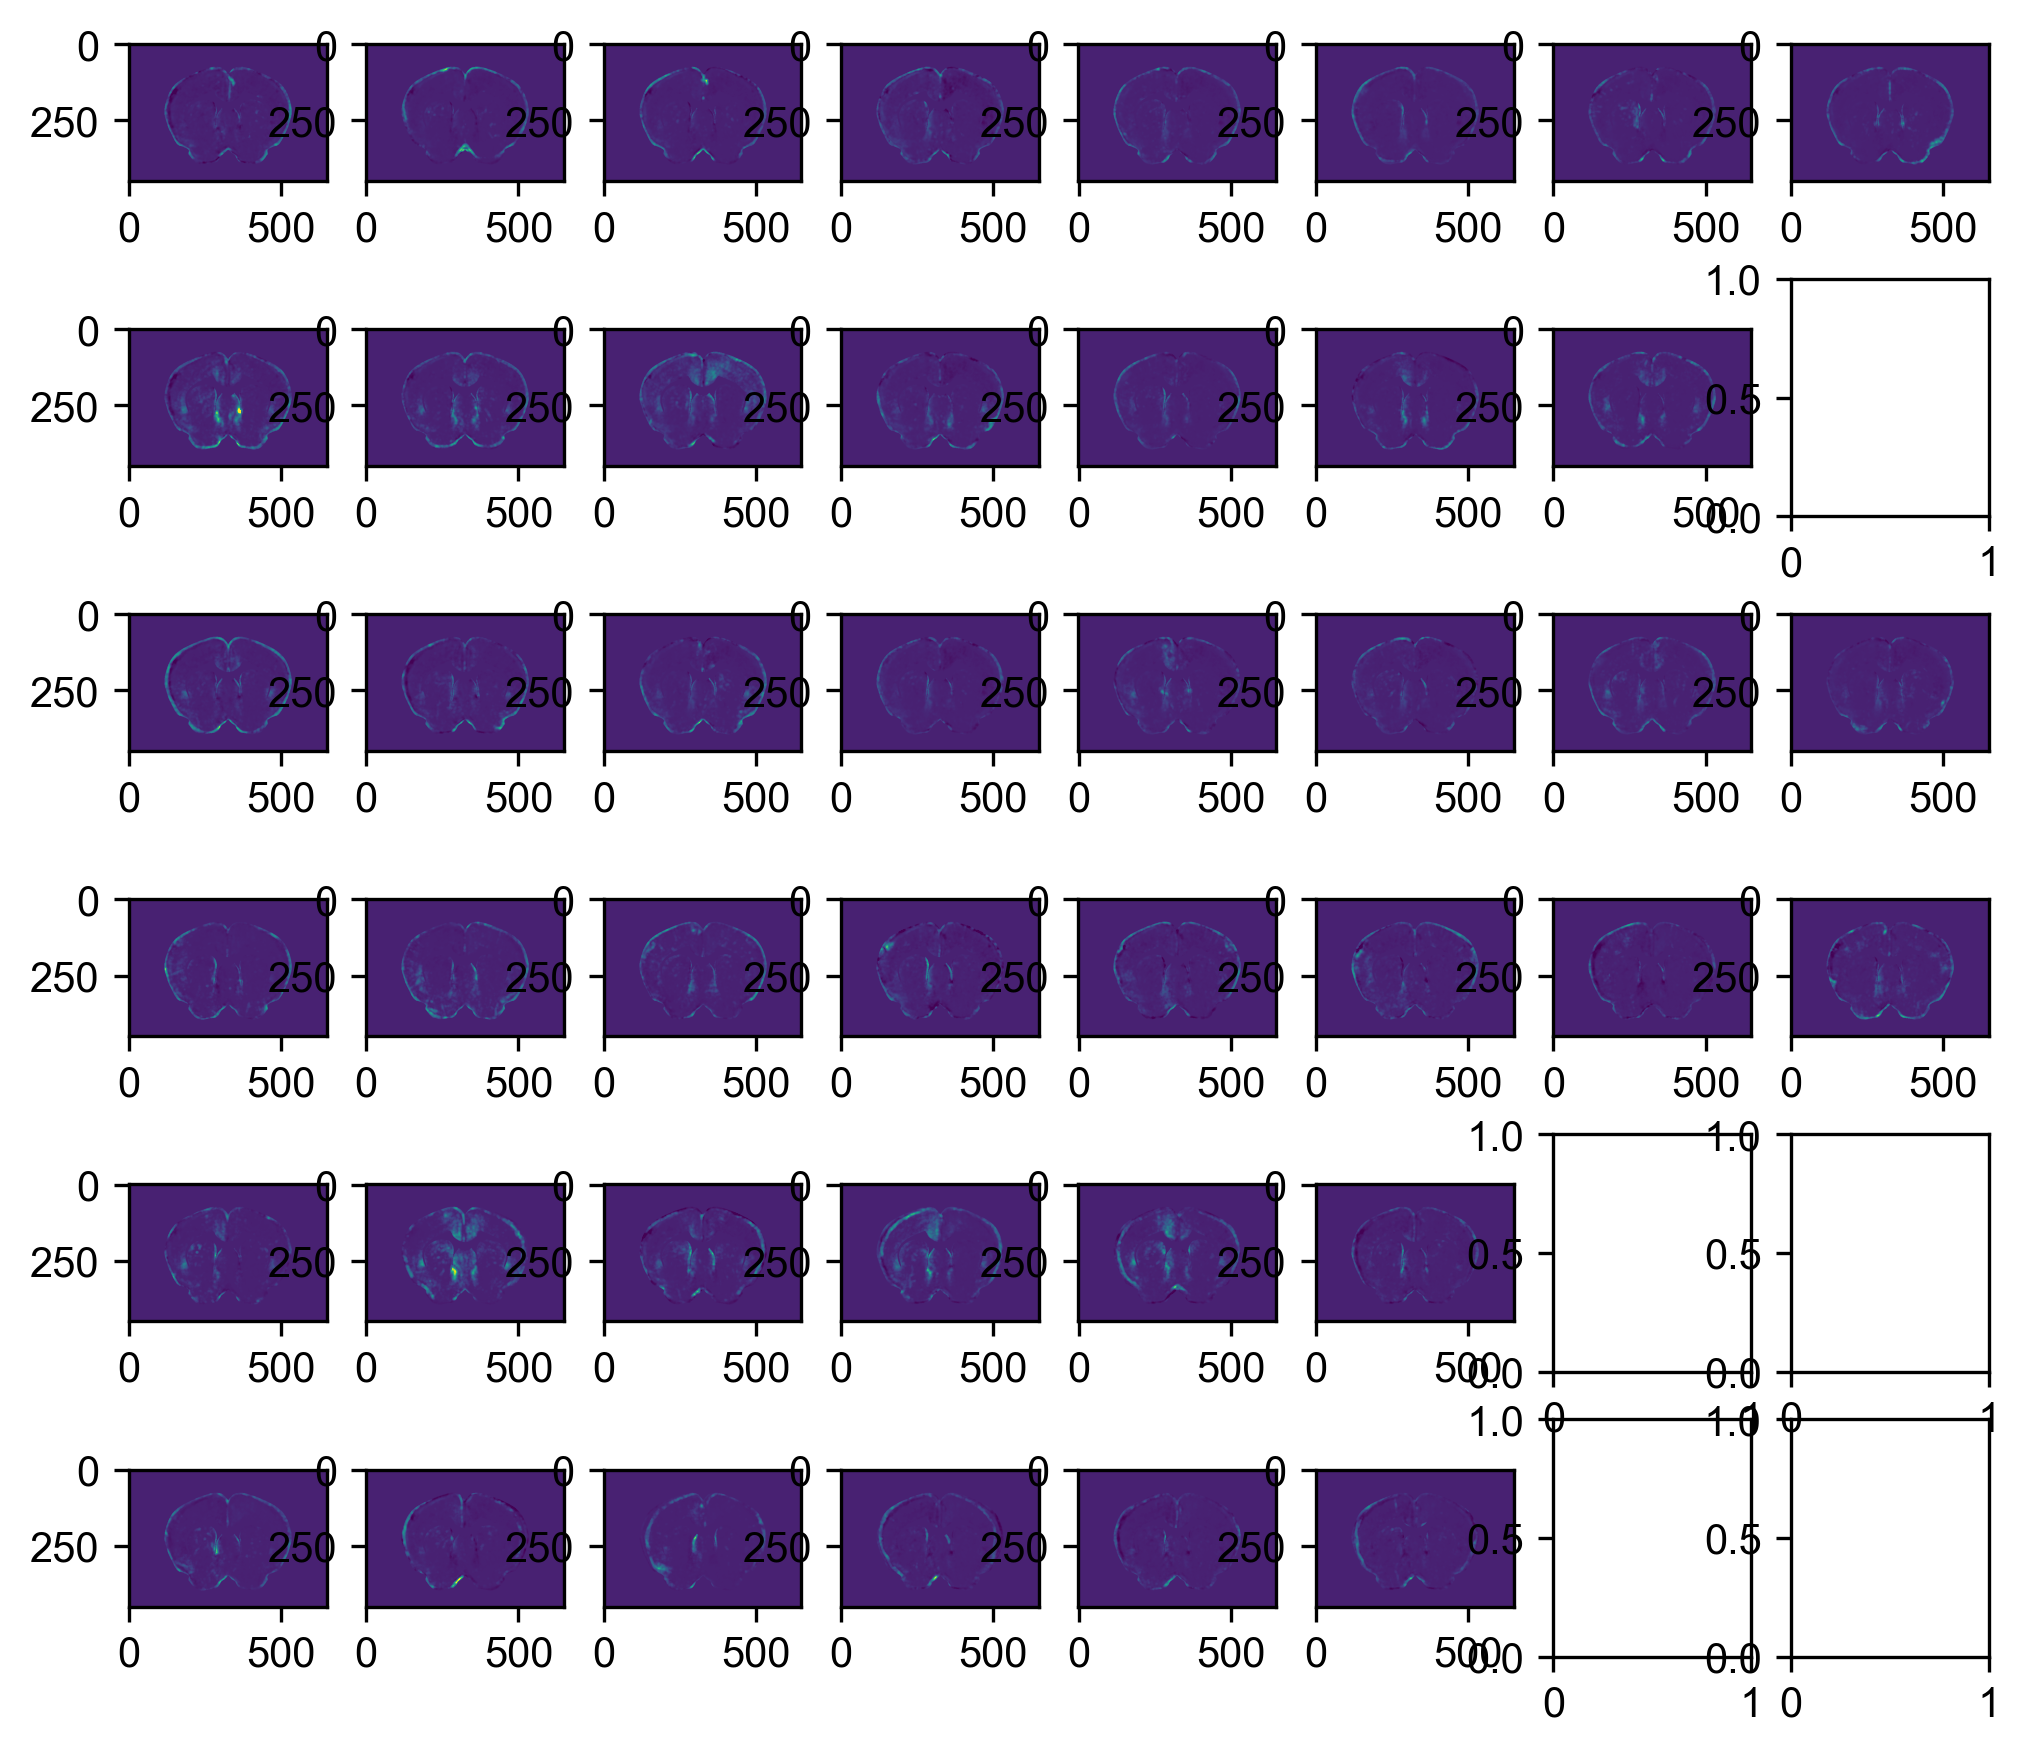

In [50]:
fig,axs = plt.subplots(len(Conditions),8,figsize = (8,len(Conditions)*1.2),dpi = 300)
for idx,condition in enumerate(Conditions):
    for sidx in range(np.sum(metadf.Condition == condition)):
        axs[idx,sidx].imshow(adjusted_brain_heatmap_da[metadf.Condition == condition,:][sidx,:]\
                             .reshape(atlas_img.shape)[100,:,:],vmin = -10,vmax = 100)

In [48]:
del adjusted_brain_heatmap_da

### Plot and save the result

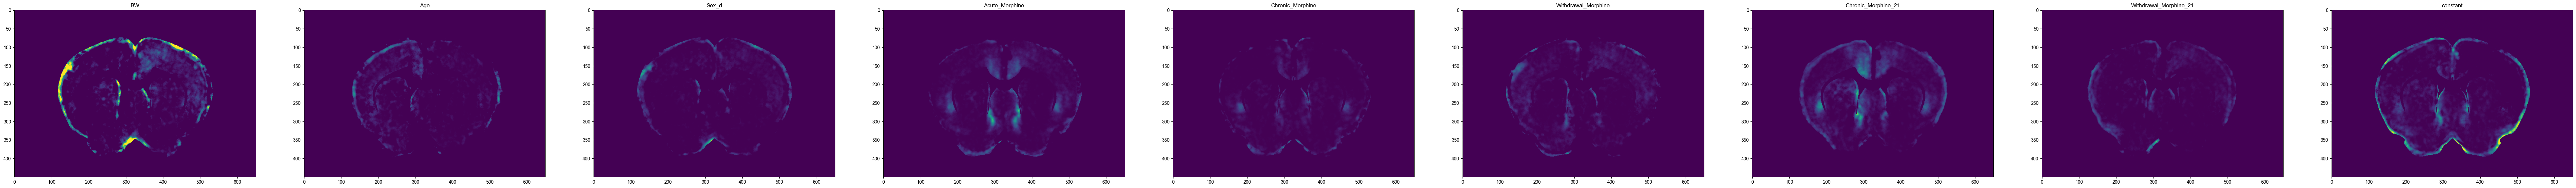

In [65]:
fig,axs = plt.subplots(1,variable_df.shape[1]-1,figsize = (10*variable_df.shape[1]-1,10))
for variable_idx,variable_name in enumerate(variable_df.columns):
    if variable_idx == 0:
        continue
    temp_img = np.zeros_like(atlas_img.flatten(),dtype='float64')
    temp_img[brain_voxels] = models.params[variable_idx-1,:]
    axs[variable_idx-1].imshow(np.reshape(temp_img,atlas_img.shape).T[:,:,100].T,vmin = 0, vmax=  50)
    axs[variable_idx-1].set_title(variable_name)

## Figure 1C

In [96]:
import numpy as np

def set_transparency(rgba_img, mask):
    """
    Applies a transparency mask to an existing RGBA image.

    Parameters:
    - rgba_img: np.ndarray of shape (H, W, 4), dtype uint8
        The input RGBA image.
    - mask: np.ndarray of shape (H, W), dtype bool
        Boolean mask where True means the pixel should be transparent.

    Returns:
    - np.ndarray of shape (H, W, 4), modified RGBA image.
    """
    if rgba_img.shape[-1] != 4:
        raise ValueError("Input image must be RGBA (shape must be H x W x 4).")
    if rgba_img.shape[:2] != mask.shape:
        raise ValueError("Mask shape must match image height and width.")

    # Copy to avoid modifying the original
    result = rgba_img.copy()
    result[mask, 3] = 0  # Set alpha to 0 (transparent) where mask is True
    return result


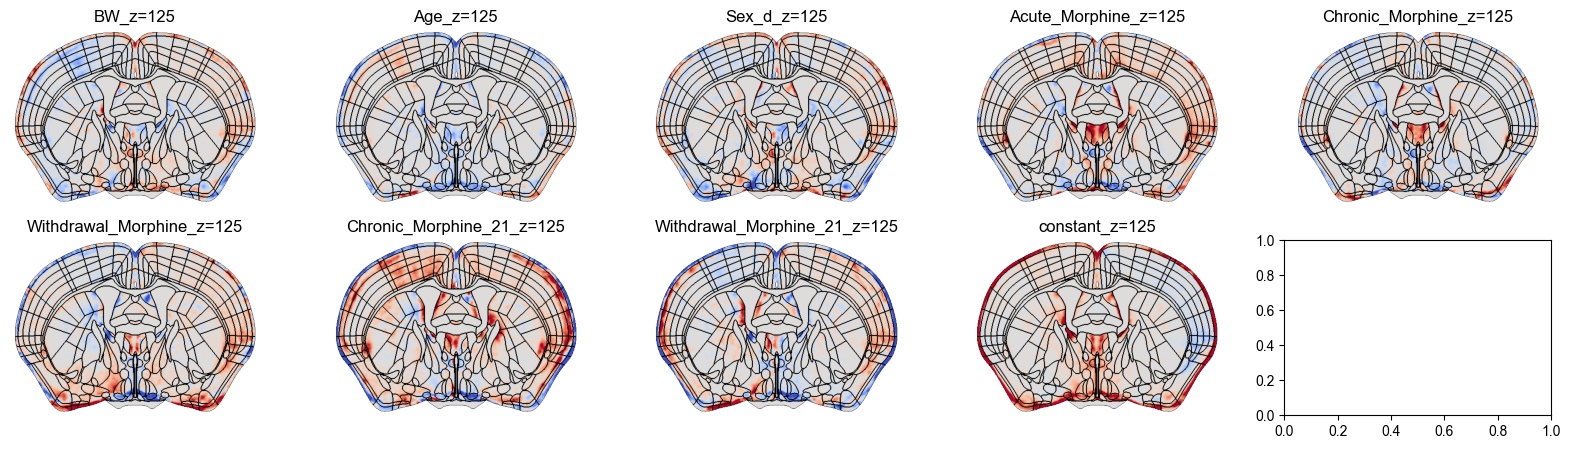

In [97]:
import tifffile
pannel_key = 'C'
# read the variable
# slice for visualization
imy_slice = slice(50,400)
imx_slice = slice(75,575)
zplace = 125
fig,axs = plt.subplots(2,int(np.ceil(len(variable_df.columns)/2)),
figsize = (20,np.ceil(len(variable_df.columns)/2)))
for cidx,variable_name in enumerate(variable_df.columns):
    ax = axs.flatten()[cidx]
    #variable_name = 'Chronic_Morphine'
    beta_array = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'{variable_name}_betas.npy'))
    # run the overlap script
    base_image_color,overlayed_image = overlap_contour(beta_array,contour_img,\
        cmin =  -15, cmax = 15,\
        outputpath = False)
        #outputpath = os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'{variable_name}_betacoef_contour_overlap.tif'))
    #tifffile.imwrite(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'{variable_name}_betacoef_contour_overlap.tif'), overlayed_image)
    # Step 5: Extract zplace = 100 slice and display the image
    trans_img = set_transparency(overlayed_image[zplace,:,:], (atlas_img==0)[zplace,:,:])
    #ax.figure(figsize=(10, 10))
    ax.imshow(trans_img[imy_slice, imx_slice,])
    ax.axis('off')
    ax.set_title(f'{variable_name}_z={zplace}')
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),dpi = 216,bbox_inches='tight')
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),dpi = 216,bbox_inches='tight')

## Figure 1D

In [98]:
# pannel
pannel_key = 'D'

In [99]:
# pre selected zplanes
curated_zplanes = [84,104,117,153,186,220]

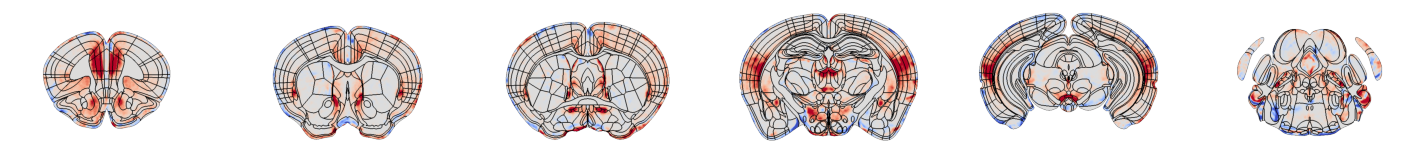

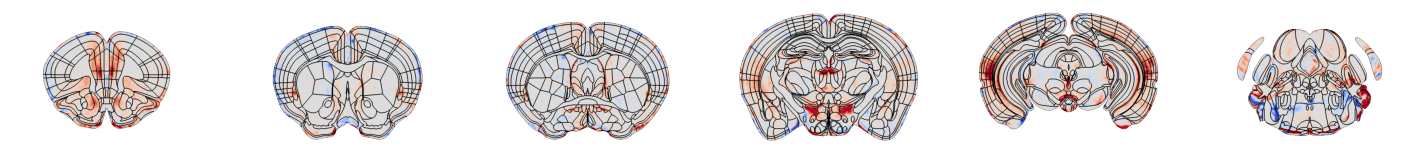

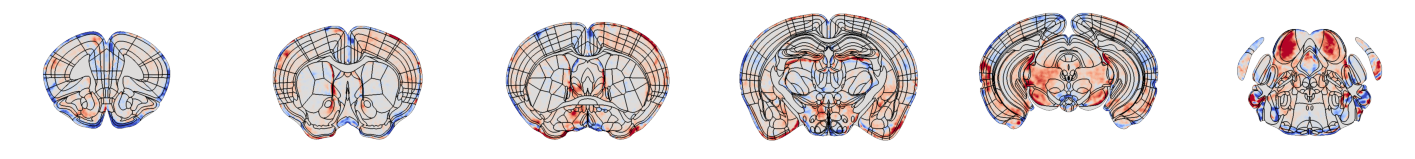

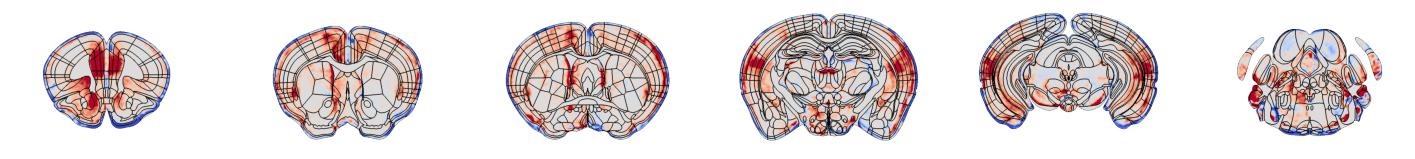

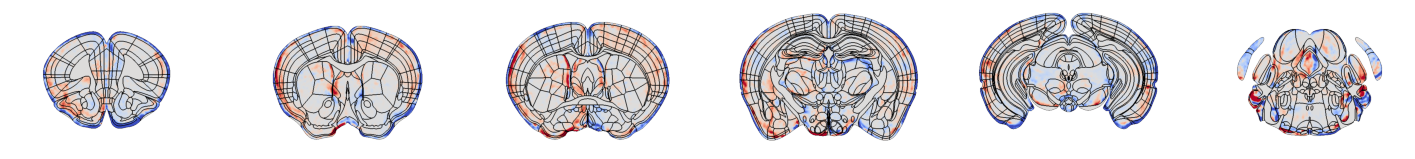

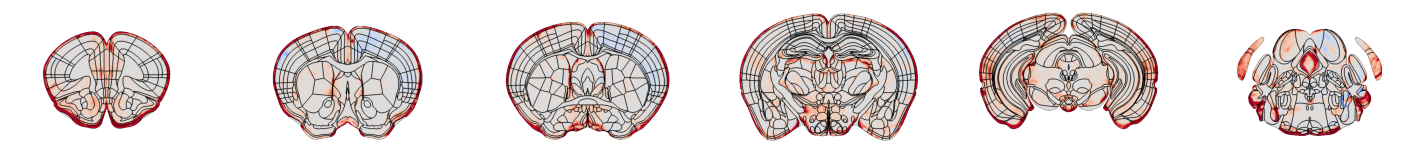

In [100]:
# plot every 10 zplanes
# slice for visualization
imy_slice = slice(25,425)
imx_slice = slice(50,600)
for condition in Conditions[1:] + ['constant']:
    theatmap = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'{condition}_betas.npy'))
    __,overlayed_image = overlap_contour(theatmap,contour_img,\
    cmin =  -15, cmax = 15,\
    outputpath = None)
    fig,axs = plt.subplots(1,len(curated_zplanes),figsize = (3*len(curated_zplanes),3),sharey = True)
    fig.subplots_adjust(wspace=0.25, hspace=0.3)

    for idx,ax in enumerate(axs):
        formatted_idx = f"{curated_zplanes[idx]:04}" 
        

        trans_img = set_transparency(overlayed_image[curated_zplanes[idx],:,:], (atlas_img==0)[curated_zplanes[idx],:,:])
        ax.imshow(trans_img[imy_slice,imx_slice])
        ax.axis('off')
        ax.set_title('')
        ax.set_ylabel(condition,color = 'black')
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{condition}_betacoef.png'),bbox_inches='tight',dpi = 1024)
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{condition}_betacoef.pdf'),bbox_inches='tight',dpi = 1024)

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\dask\array\core.py:1721: FutureWarning: The `numpy.min_scalar_type` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0

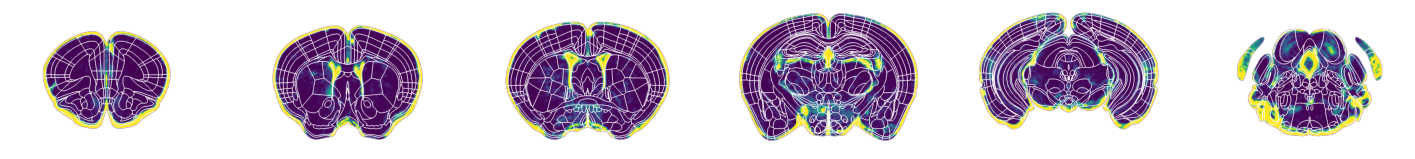

In [ ]:
# plot every 10 zplanes
# plot for the saline condition
# slice for visualization
import contour_visualization2 as cv2
imy_slice = slice(25,425)
imx_slice = slice(50,600)
condition = 'Saline'
theatmap = np.mean(heatmap_da[(metadf.Condition =='Saline'),:],axis = 0).reshape(atlas_img.shape)

fig,axs = plt.subplots(1,len(curated_zplanes),figsize = (3*len(curated_zplanes),3),sharey = True)
fig.subplots_adjust(wspace=0.25, hspace=0.3)

for idx,ax in enumerate(axs):
    formatted_idx = f"{curated_zplanes[idx]:04}" 
    
    __,overlayed_image = cv2.overlap_contour(theatmap,contour_img,\
    cmin =  0, cmax = 10,\
    outputpath = None,colormap = plt.cm.viridis)
    trans_img = set_transparency(overlayed_image[curated_zplanes[idx],:,:], (atlas_img==0)[curated_zplanes[idx],:,:])
    ax.imshow(trans_img[imy_slice,imx_slice])
    ax.axis('off')
    ax.set_title('')
    ax.set_ylabel(condition,color = 'black')
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{condition}_mean.png'),bbox_inches='tight',dpi = 1024)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{condition}_mean.pdf'),bbox_inches='tight',dpi = 1024)